# Data Structures

In [1]:
# Set to enable auto-complete for subclass properties
# See: https://github.com/ipython/ipython/issues/11653#issuecomment-492578777
%config Completer.use_jedi = False
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
from lib import api
xr.set_options(display_style='html')

## Overview

Pseudo-types are provided as a way to provide domain specific semantics on top of `xarray.Dataset` instances.  These types are included as attributes within the array and specific APIs relevent to them are exposed through Xarray [accessors](https://salem.readthedocs.io/en/latest/xarray_acc.html).  This enables the following:

- Enforcement of type, data variable, and coordinate constraints to ensure that functions in the rest of the API are compatible.
- Natural "transmutation" operations (e.g. converting genotype probabilities to dosages)
- More intuitive documentation

Types included in this prototype:

- [GenotypeCallDataset]() _(variant, sample, ploidy)_ -> _allele index_: This class models genotype calls as allele indexes in an array for each variant, sample, and chromosome 
- [HaplotypeCallDataset]() _(variant, sample)_ -> _allele index_: This class models haplotype calls (i.e. calls for a single chromosome)
- [GenotypeProbabilityDataset]() _(variant, sample, ploidy, allele)_ -> _allele probability_: This class models probabilistic calls, e.g. from genotype imputation.
- [GenotypeCountDataset]() _(variant, sample)_ -> _allele count_: This class models counts of alternate alleles
- [GenotypeDosageDataset]() _(variant, sample)_ -> _allele dosage_: This class models dosages computed from probabilistic calls as floating point values in \[0, 2\]
- [GenotypeAlleleCountDataset]() _(variant, sample, ploidy)_ -> _(allele index, allele count)_: This class maintains both allele indexes and counts simultaneously, primarily for copy number datasets

Instances of these "types" are constructed through factory methods (`api.create_*_dataset`), but all data structures are simply `xarray.Dataset` objects.  They do not need to be built using the API, though doing it that way is much safer.  

Finally, API methods will not validate that provided Dataset instances have an associated type (through `attrs`).  This means that the pseudo-type system is essentially invisible to users, and they can directly modify datasets without worrying about propagating API-specific properties, however these types will be used internally to validate that provided Datasets meet the constraints of those types (i.e. using structural typing, not nominal typing).

### Creating Datasets

In [2]:
# 10 variants, 5 samples, and 2 chromosomes for which hard calls are simulated
shape = (10, 5, 2)

In [3]:
# From numpy:
gt = np.random.randint(0, 2, size=shape, dtype=np.uint8) # Draw from [0, 1] where 0 = ref allele and 1 = alt allele 
gt = api.create_genotype_call_dataset(gt, attrs={'description': 'Bi-allelic, diploid hard call array example [numpy]'})
gt

<xarray.Dataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 0 0 1 1 1 1 0 0 ... 1 1 1 1 0 0 1 1
Attributes:
    description:  Bi-allelic, diploid hard call array example [numpy]
    type:         GenotypeCallDataset

In [4]:
# From dask, with phase information:
gt = da.random.randint(0, 2, size=shape, dtype=np.uint8)
ip = da.random.randint(0, 2, size=shape[:-1]).astype(bool) # Simulate phasing per call
gt = api.create_genotype_call_dataset(data=gt, is_phased=ip, attrs={'description': 'Bi-allelic, diploid hard call array example [dask]'})
gt

<xarray.Dataset>
Dimensions:    (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant    (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample     (sample) int64 0 1 2 3 4
  * ploidy     (ploidy) int64 0 1
Data variables:
    data       (variant, sample, ploidy) uint8 dask.array<chunksize=(10, 5, 2), meta=np.ndarray>
    is_phased  (variant, sample) bool dask.array<chunksize=(10, 5), meta=np.ndarray>
Attributes:
    description:  Bi-allelic, diploid hard call array example [dask]
    type:         GenotypeCallDataset

In [5]:
gt.data.data

dask.array<randint, shape=(10, 5, 2), dtype=uint8, chunksize=(10, 5, 2), chunktype=numpy.ndarray>

In [6]:
# From xarray (gt already has an Xarray DataArray in `.data` attribute)
api.create_genotype_call_dataset(gt.data)

<xarray.Dataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 dask.array<chunksize=(10, 5, 2), meta=np.ndarray>
Attributes:
    type:     GenotypeCallDataset

To represent more complex structures, such as CNV data for a multi-allelic, polyploid experiment, multiple arrays can be used if a single array representation is either inefficient or impossible.  For example, it would be possible to represent CNV data as a 4D array with shape ```(variants, samples, ploidy, allele)``` where individual values correspond to allele count on one chrosome.  This may be very inefficient though if the size of the ```allele``` dimension is much larger than the size of the ```ploidy``` dimension (e.g. supporting up to say 5 alleles with a ploidy of 2 means at least 3 zeros will be present in every vector along the last dimension).  The allele index and counts can be maintained separately to avoid this:

In [7]:
# Create an array containing hard calls where values correspond to allele index (up to at most 5 alleles possible in this case)
gt_idx = np.random.randint(0, 5, size=shape, dtype=np.uint8)

# Create an array containing the copy numbers as counts of the alleles above on each chromosome
gt_cts = np.random.randint(0, 10, size=shape, dtype=np.uint8)

# Combine the two arrays into a single dataset
gt_cnv = api.create_genotype_allele_count_dataset(gt_cts, gt_idx, attrs={'name': 'CNV Dataset Example (data = allele count, indexes = allele index)'})
gt_cnv

<xarray.Dataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 3 0 6 7 7 1 8 1 ... 5 7 0 9 2 1 9 4
    indexes  (variant, sample, ploidy) uint8 1 4 1 2 1 3 1 2 ... 0 2 1 3 1 2 0 3
Attributes:
    name:     CNV Dataset Example (data = allele count, indexes = allele index)
    type:     GenotypeAlleleCountDataset

### Transmutation

The API facilitates conversions to different representations (where possible) through methods in the `to` accessor namespace.  These conversions often result in a loss of information (e.g. reductions across a dimension) -- i.e. they are not invertible.  This makes it easy for an analysis to start with a complex N-dimensional structure and call these conversions where needed as inputs to algorithms that generally expect simpler structures.  Examples of this include: 

- Converting calls to alternate allele counts for LD estimation
- Encoding calls for regression as dominant or recessive, with special considerations for sex chromosomes
- Calculating gene dosages from probabilistic calls
- Extracting haplotypes from phased genotypes

The examples below show a few of these:

#### Hard Calls to Alt Allele Counts

In [8]:
# Simulate an array of diploid, multi-allelic hard calls
gt = np.random.randint(0, 3, size=shape, dtype=np.uint8) # Draw from [0, 2]
gt = api.create_genotype_call_dataset(gt, attrs={'description': 'Calculating alt allele count from hard calls'})
gt

<xarray.Dataset>
Dimensions:  (ploidy: 2, sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
  * ploidy   (ploidy) int64 0 1
Data variables:
    data     (variant, sample, ploidy) uint8 2 1 2 1 1 0 0 1 ... 2 2 0 2 0 1 2 0
Attributes:
    description:  Calculating alt allele count from hard calls
    type:         GenotypeCallDataset

In [9]:
# Convert to number of alternate alleles across all chromosomes for each variant + sample combination
ct = gt.to.genotype_count_dataset()
ct

<xarray.Dataset>
Dimensions:  (sample: 5, variant: 10)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4
Data variables:
    data     (variant, sample) int64 2 2 1 1 1 2 2 1 2 0 ... 0 1 1 1 1 2 2 1 1 1
Attributes:
    description:  Calculating alt allele count from hard calls
    type:         GenotypeCountDataset

In [10]:
# This is the usual input many genetics methods operate on
ct.data.to_pandas()

sample,0,1,2,3,4
variant,,,,,
0,2,2,1,1,1
1,2,2,1,2,0
2,1,2,1,1,1
3,2,2,2,1,1
4,1,0,2,1,2
5,2,1,2,2,1
6,0,2,1,2,1
7,2,2,2,1,1
8,0,1,1,1,1


In [11]:
# Ignoring masks, the above is the same as this 
(gt.data > 0).sum(dim='ploidy')

<xarray.DataArray 'data' (variant: 10, sample: 5)>
array([[2, 2, 1, 1, 1],
       [2, 2, 1, 2, 0],
       [1, 2, 1, 1, 1],
       [2, 2, 2, 1, 1],
       [1, 0, 2, 1, 2],
       [2, 1, 2, 2, 1],
       [0, 2, 1, 2, 1],
       [2, 2, 2, 1, 1],
       [0, 1, 1, 1, 1],
       [2, 2, 1, 1, 1]])
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample   (sample) int64 0 1 2 3 4

#### Probabilities to Dosage

If the genotype calls for an experiment are imputed (or probabilistic for some other reason), this is what converting to dosage looks like:

In [12]:
# Simulate allele probability array with dims (variant, sample, ploidy, allele)
gp = np.random.rand(1000, 100, 2, 2)
# Convert random values to probabilities so that the sum of values across alleles is 1
gp /= gp.sum(axis=-1, keepdims=True)
gp.shape

(1000, 100, 2, 2)

In [13]:
# Show a single vector of allele probabilities for one variant + sample + chromosome
gp[0, 0, 0]

array([0.63445472, 0.36554528])

In [14]:
gp = api.create_genotype_probability_dataset(gp, attrs={'description': 'Genotype probability example'})
gp

<xarray.Dataset>
Dimensions:  (allele: 2, ploidy: 2, sample: 100, variant: 1000)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * ploidy   (ploidy) int64 0 1
  * allele   (allele) int64 0 1
Data variables:
    data     (variant, sample, ploidy, allele) float64 0.6345 0.3655 ... 0.4988
Attributes:
    description:  Genotype probability example
    type:         GenotypeProbabilityDataset

In [15]:
# Dosages will be calculated as Pr(Heterozygous) + 2 * Pr(Homozygous Alternate) (Allele 0 assumed as reference)
gpd = gp.to.genotype_dosage_dataset()
gpd

<xarray.Dataset>
Dimensions:  (sample: 100, variant: 1000)
Coordinates:
  * variant  (variant) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * sample   (sample) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    data     (variant, sample) float64 0.7807 0.7738 1.248 ... 0.8099 0.7476
Attributes:
    description:  Genotype probability example
    type:         GenotypeDosageDataset

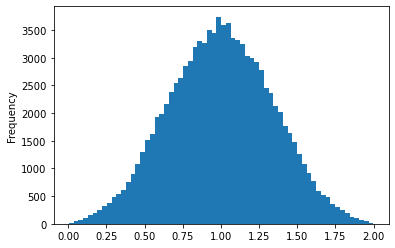

In [16]:
# Show histogram of dosage values in [0, 2]
gpd.data.to_pandas().stack().plot(kind='hist', bins=64)

### Missing Data

Missing data is represented as masked arrays.  Masking is not supported by Xarray directly so this state is ultimately stored as a separate variable in a dataset, but it still provides a convenient mechanism for marking absent array elements when constructing such a dataset.  Masks can be supplied explicitly though if that is more convenient/efficient.

In [17]:
shape = (8, 4)
ht = da.ma.masked_array(
    # Genotype calls (in [0, 1])
    np.random.randint(0, 2, size=shape, dtype=np.int8), 
    # Mask values are True or False where True indicates missing
    np.random.choice([False, True], size=shape, p=[.8, .2])
)
ht = api.create_haplotype_call_dataset(ht)
ht

<xarray.Dataset>
Dimensions:    (sample: 4, variant: 8)
Coordinates:
  * variant    (variant) int64 0 1 2 3 4 5 6 7
  * sample     (sample) int64 0 1 2 3
Data variables:
    data       (variant, sample) int8 dask.array<chunksize=(8, 4), meta=np.ndarray>
    is_masked  (variant, sample) bool dask.array<chunksize=(8, 4), meta=np.ndarray>
Attributes:
    type:     HaplotypeCallDataset

In [18]:
ht.data.to_pandas().assign(nasum=(ht.data * ~ht.is_masked).sum(dim='sample').to_pandas())

sample,0,1,2,3,nasum
variant,,,,,
0,1,1,0,1,3
1,0,-1,1,-1,1
2,0,1,-1,1,2
3,0,0,-1,-1,0
4,1,1,0,0,2
5,0,0,0,0,0
6,0,0,0,0,0
7,0,0,1,1,2


In [19]:
ht.is_masked.to_pandas()

sample,0,1,2,3
variant,,,,
0,False,False,False,False
1,False,True,False,True
2,False,False,True,False
3,False,False,True,True
4,False,False,False,False
5,False,False,False,False
6,False,False,False,False
7,False,False,False,False


### Underlying Types

Underlying types for arrays backing the API datasets are not strictly enforced to be a specific `dtype`, but they are often required to descend from certain query types in the [numpy type hierarchy](https://github.com/numpy/numpy/blob/52c9e6f2e3e72081576fc7f629fe3eb0c67b143b/numpy/core/numerictypes.py#L42).  Integers and floating point values can be of any bit-depth (e.g. ```np.uint8```, ```np.int32```, ```np.float128```, ```np.float16```) and should be chosen based on limitations of downstream operations (128-bit floats will likely not be supported by GPU-based array implementations), properties of individual datasets (e.g. genotyping over HLA loci w/ more than 128 alleles), and/or user preferences for the contention between memory usage and precision. 

For example:

In [20]:
def get_dataset(dtype, shape=(10, 10)):
    return api.create_haplotype_call_dataset(np.ma.masked_array(
        np.random.randint(0, 2, size=shape, dtype=dtype), 
        np.random.choice([False, True], size=shape, p=[.8, .2])
    ))

In [21]:
# Call data can be unsigned integers, but only if no values are missing (i.e. this should raise ValueError)
try:
    get_dataset(np.uint64)
except ValueError as e:
    print(e)

Mask filling with negative value not supported for unsigned integer types (fill_value = -1, dtype = uint64)


In [22]:
# Otherwise, any signed integer type will do
get_dataset(np.int64)

<xarray.Dataset>
Dimensions:    (sample: 10, variant: 10)
Coordinates:
  * variant    (variant) int64 0 1 2 3 4 5 6 7 8 9
  * sample     (sample) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    data       (variant, sample) int64 1 1 0 1 -1 0 1 1 0 ... 1 -1 0 0 0 -1 0 1
    is_masked  (variant, sample) bool False False False ... True False False
Attributes:
    type:     HaplotypeCallDataset